# Group Work Submission 3: Simulate Asset Price Evolutions and Reprice Risky up-and-out Call Option

*(Referencies: MScFE 630 CF_Compiled_Notes_M5, MScFE 630 CF_Compiled_Notes_M6, MScFE 630 CF_Compiled_Notes_M7)*

The goal of Submission 3 is to reprice the risky up-and-out call option from Submission 1, but now implementing a non constant interest rate and local volatility. With the exception of the interest rates and volatilities, you may make the same assumptions as in Submission 1:

* Option maturity is one year
* The option is struck at-the-money
* The up-and-out barrier for the option is 150
* The current share price is 100
* The risk-free continuously compounded interest rate is 8%
* The current firm value for the counterparty is 200
* The counterparty’s debt, due in one year, is 175
* The correlation between the counterparty and the stock is constant at 0.2
* The recovery rate with the counterparty is 25%.

The following zero-coupon bond prices (per 100 nominal) in the market:

    Maturity  Price
    
     1 month   99.38
     2 months  98.76
     3 months  98.15
     4 months  97.54
     5 months  96.94
     6 months  96.34
     7 months  95.74
     8 months  95.16
     9 months  94.57
    10 months  93.99
    11 months  93.42
    12 months  92.85

# Part 1

Using a sample size of 100000, jointly simulate LIBOR forward rates, stock paths, and counterparty firm values. You should simulate the values monthly, and should have LIBOR forward rates applying over one month, starting one month apart, up to maturity. You may assume that the counterparty firm and stock values are uncorrelated with LIBOR forward rates.

Importing libraries:

In [1]:
import numpy as np
import pandas as pd
import math
import random
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import log,exp,sqrt,stats
import scipy.stats as si
from scipy.stats import ncx2
import warnings
import scipy as sp
import scipy.optimize
import py_vollib
warnings.filterwarnings("ignore")
%matplotlib inline

Parameters:

In [2]:
#Parameters:
r = 0.08 #Risk free rate
#Share specific information
S_0 = 100 #Current share price
sigma_stock = 0.3 #Volatility
#Option specific information
K = S_0    #Strike as it`s at-the-money option
B = 150   #up-and-out barrier
T = 1 #Maturity
sigma_const = 0.30
gamma = 0.75
#Firm specific information
V_0 = 200 #Initial firm value
sigma_firm = 0.2 #Firm value volatility
debt = 175       #Debt of the firm
recovery_rate = 0.25
corr = 0.2    #Correlation between the counterparty and the stock price
dT = 1/12 #monthly simulations
#Problem parameters
corr_matrix = np.array([[1, corr], [corr, 1]]) #Correlation Matrix
L = np.linalg.cholesky(corr_matrix) #Cholesky decomposition
sigmaj = 0.2

Putting the zero-coupon bond prices into an array:

In [3]:
zero_coupon_prices = np.array([1.0, 0.9938, 0.9876, 0.9815, 0.9754, 0.9694, 0.9634, 0.9574, 
                               0.9516, 0.9457, 0.9399, 0.9342, 0.9285])

Creating a yield curve for integer maturities:

In [4]:
years = np.linspace(0,1,13)

First we need to calibrate our model, for this we will import the functions from the MScFE 630 CF_Compiled_Notes_M7:

In [5]:
#Analytical bond price Vasicek
def A(t1,t2,alpha):
    return (1-np.exp(-alpha*(t2-t1)))/alpha

def D(t1,t2,alpha,b,sigma):
    val1 = (t2-t1-A(t1,t2,alpha))*(sigma**2/(2*alpha**2)-b)
    val2 = sigma**2*A(t1,t2,alpha)**2/(4*alpha)
    return val1-val2

def bond_price_fun(r,t,T,alpha,b,sigma):
    return np.exp(-A(t,T,alpha)*r+D(t,T,alpha,b,sigma))


def F(x):
    r0 = x[0]
    alpha = x[1]
    b = x[2]
    sigma = x[3]
    #return sum((bond_price_fun(r0,0,years,alpha,b,sigma)-bond_prices)**2)
    return sum(np.abs(bond_price_fun(r0,0,years,alpha,b,sigma)-zero_coupon_prices))

Minimizing F:

In [6]:
bnds = ((0,0.2),(0,5),(0,0.5),(0,2))
opt_val = sp.optimize.fmin_slsqp(F, (0.05,0.3,0.05,0.03), bounds=bnds)
r0 = opt_val[0]
opt_alpha = opt_val[1]
opt_b = opt_val[2]
opt_sig = opt_val[3]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.00024383604073308085
            Iterations: 11
            Function evaluations: 75
            Gradient evaluations: 11


Let`s print out the numbers:

In [7]:
print("optimal alpha: {:.3f}".format(opt_alpha))
print("optimal b: {:.3f}".format(opt_b))
print("optimal sigma {:.3f}".format(opt_sig))
print("optimal short-term rate: {:.3f}".format(r0))

optimal alpha: 0.279
optimal b: 0.071
optimal sigma 0.036
optimal short-term rate: 0.075


Calculating the model prices and the model yields:

In [8]:
model_prices = bond_price_fun(r0,0,years, opt_alpha, opt_b, opt_sig)

Plotting the market vs model prices:

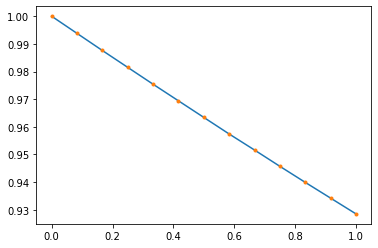

In [9]:
plt.plot(years, zero_coupon_prices)
plt.plot(years, model_prices, '.')
plt.show()

Now, we will generate bond prices based on Vasicek dynamics, using the functions from the MScFE 630 CF_Compiled_Notes_M6:

In [10]:
# Vasicek Bond prices
def A(t1,t2):
    return (1-np.exp(-opt_alpha*(t2-t1)))/opt_alpha

def C(t1,t2):
    val1 = (t2-t1-A(t1,t2))*(opt_sig**2/(2*opt_alpha**2)-opt_b)
    val2 = opt_sig**2*A(t1,t2)**2/(4*opt_alpha)
    return val1-val2

def bond_price(r,years,T):
    return np.exp(-A(years,T)*r+C(years,T))

vasi_bond = bond_price(r0,0,years)

In [11]:
print("Vasicek Bond prices:", vasi_bond*100)

Vasicek Bond prices: [100.          99.37813391  98.76100372  98.14861882  97.54098348
  96.93809722  96.33995521  95.74654858  95.15786476  94.57388781
  93.99459864  93.41997533  92.84999336]


Creating matrices in order to vectorize the code:

In [12]:
# Applying the algorithms
np.random.seed(10)
n_simulations = 100000
n_steps = len(years)

mc_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(vasi_bond[1:])
predcorr_forward = np.ones([n_simulations, n_steps-1])*(vasi_bond[:-1]-vasi_bond[1:])/(vasi_bond[1:])
predcorr_capfac = np.ones([n_simulations, n_steps])
mc_capfac = np.ones([n_simulations, n_steps])

delta = np.ones([n_simulations, n_steps - 1])*(years[1:]-years[:-1])

Running Monte Carlo simulation:

In [13]:
for i in range(1, n_steps):
    Z = norm.rvs(size=[n_simulations,1])
    #Explicit Monte Carlo simulation
    muhat = np.cumsum(delta[:, i:]*mc_forward[:, i:]*sigmaj**2/(1+delta[:, i:]*mc_forward[:,i:]), axis=1)
    mc_forward[:,i:] = mc_forward[:,i:]*np.exp((muhat-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    #Predictor-Corrector Monte Carlo Simulation
    mu_initial = np.cumsum(delta[:,i:]*predcorr_forward[:,i:]*sigmaj**2/(1+delta[:,i:]*predcorr_forward[:,i:]), axis=1)
    for_temp = predcorr_forward[:,i:]*np.exp((mu_initial-sigmaj**2/2)*delta[:,i:]+sigmaj*np.sqrt(delta[:,i:])*Z)
    mu_term = np.cumsum(delta[:,i:]*for_temp*sigmaj**2/(1+delta[:,i:]*for_temp), axis=1)
    predcorr_forward[:,i:] = predcorr_forward[:,i:]*np.exp((mu_initial+mu_term-sigmaj**2)*delta[:,i:]/
                                                           2+sigmaj*np.sqrt(delta[:,i:])*Z)

Next step is to imply capitalisation factors:

In [14]:
#Implying capitalisation factors from the forward rates
mc_capfac[:,1:] = np.cumprod(1+mc_forward, axis=1)
predcorr_capfac[:,1:] = np.cumprod(1+predcorr_forward, axis=1)
#Inverting the capitalistation factors to imply bond prices (discount factors)
mc_price = mc_capfac**(-1)
predcorr_price = predcorr_capfac**(-1)
#Taking averages
mc_final = np.mean(mc_price, axis=0)
predcorr_final = np.mean(predcorr_price, axis=0)

Plotting the result:

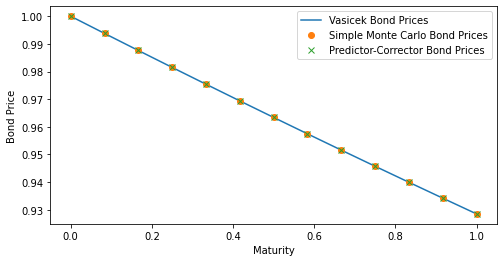

In [15]:
plt.subplots(figsize=(8, 4))
plt.xlabel("Maturity")
plt.ylabel("Bond Price")
plt.plot(years,vasi_bond, label = "Vasicek Bond Prices")
plt.plot(years,mc_final,'o', label = "Simple Monte Carlo Bond Prices")
plt.plot(years,predcorr_final,'x', label = "Predictor-Corrector Bond Prices")
plt.legend()
plt.show()

Now, we can calculate the continuous compounded interest rates using the given formula:

$e^{r_{t_i} (t_{i+1}-t_i)} = 1 + L(t_i,t_{i+1})(t_{i+1}-t_i)$

In [16]:
libor_forward = np.log(1 + predcorr_forward*(delta))/delta

Calculation of the Annual Interest Rates and putting them into a data frame:

In [17]:
libor_forward_pd = pd.DataFrame(libor_forward/delta)
libor_forward_pd.T

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,0.075071,0.075071,0.075071,0.075071,0.075071,0.075071,0.075071,0.075071,0.075071,0.075071,...,0.075071,0.075071,0.075071,0.075071,0.075071,0.075071,0.075071,0.075071,0.075071,0.075071
1,0.080819,0.077995,0.068454,0.074804,0.077573,0.071794,0.075996,0.075311,0.074859,0.074090,...,0.074999,0.073732,0.067904,0.075140,0.070093,0.073539,0.075647,0.075785,0.071741,0.076606
2,0.083782,0.075442,0.066810,0.081606,0.075204,0.072275,0.082570,0.071641,0.077537,0.073243,...,0.070729,0.070847,0.065843,0.072977,0.066373,0.073367,0.076789,0.076348,0.076331,0.080058
3,0.082407,0.080964,0.060329,0.079454,0.075448,0.067826,0.080699,0.076662,0.077379,0.073364,...,0.068246,0.070754,0.065386,0.072006,0.065487,0.079476,0.077258,0.075175,0.078955,0.082256
4,0.084397,0.079828,0.063573,0.083135,0.081887,0.068302,0.078406,0.076873,0.079539,0.070351,...,0.065291,0.076036,0.069513,0.074299,0.062643,0.079705,0.078789,0.081024,0.073122,0.080061
5,0.085070,0.076659,0.063168,0.082394,0.076372,0.070778,0.085136,0.077732,0.087439,0.069743,...,0.065944,0.077705,0.076104,0.072660,0.060041,0.082547,0.077657,0.082741,0.071850,0.086624
6,0.084232,0.080328,0.066337,0.085754,0.069866,0.070079,0.087018,0.078108,0.085303,0.074376,...,0.068988,0.077545,0.077745,0.076426,0.055921,0.080740,0.076438,0.082562,0.071513,0.089553
7,0.081870,0.081261,0.061508,0.081368,0.073233,0.069415,0.087021,0.077268,0.089461,0.077928,...,0.065259,0.084052,0.076899,0.076511,0.050143,0.074781,0.074159,0.075708,0.071458,0.092473
8,0.084289,0.081722,0.060935,0.082578,0.073805,0.067614,0.087704,0.074983,0.091735,0.074936,...,0.064810,0.082050,0.078646,0.081742,0.051655,0.077790,0.074370,0.078376,0.064705,0.097761
9,0.079951,0.075721,0.060936,0.081429,0.068881,0.068077,0.091742,0.076982,0.096456,0.068343,...,0.068436,0.082110,0.073550,0.085993,0.053749,0.075960,0.077953,0.082549,0.064655,0.104111


## Simulating stock and counterparty firm values:

Using Our Function from GWP 2 to simulate price paths:

In [18]:
#function for Volatility from CEV Model
def CEV_vol(sigm,sT,gamman):
    return sigm*sT**(gamman-1) 

Modified the Function from the Compiled Notes to simulate price paths:

In [19]:
def share_path(S_0, r, sigma, dT, Z):
    """Generate the price path given intial price and some random normal values, Z"""
    vol = CEV_vol(sigma,S_0,gamma)
        #sT *= np.exp((r-0.5*vol**2)*dt+vol*e*np.sqrt(dt)*Z)
    return S_0 * np.exp(np.cumsum((r - vol**2/2)*dT + vol*np.sqrt(dT)*Z, axis=0))

Importing the Terminal share price function from the Complied Notes M3 in order to calculate the terminal firm values:

In [20]:
def terminal_shareprice(S_0, risk_free, sigma, Z, T):
    """Generates the terminal share price given some random normal values, Z"""
    return  S_0 * np.exp((risk_free - sigma**2 / 2)*T + sigma*np.sqrt(T)*Z)

Function to calculate the payoff of up-and-out call option:

In [21]:
def call_payoff(share_path, K, B):
    """Calculating the payoff of up-and-out call option given a share price path."""
    if share_path.any() > B:
        return 0
    else:
        return np.maximum(share_path[-1] - K,0)

Empty array which can be used to store estimate values for different sample sizes:

In [22]:
random.seed(10)

stock_price_path=[None]*100
firm_price_path=[None]*100
up_and_out_price = [None]*100
up_and_out_price_std = [None]*100
cva_estimates = [None]*100
cva_std = [None]*100

We will calculate here the one year discount factor, so we can apply below where we run the simulations, in order to calculate the risk amount due to default risk:

In [23]:
one_year_discount_factor = 1/np.cumprod(1+libor_forward, axis=1)[:,-1]
discount_factor = one_year_discount_factor.mean()

Running the simulations:

In [24]:
for i in range(1, 101):
    norm_martix = norm.rvs(size=[12, 2, i*1000])
    corr_norm_martix = np.array([np.matmul(L, x) for x in norm_martix]) 
#Simulated share price paths:
    stock_price = np.array([share_path(S_0, r, sigma_stock, dT, Z_share) for Z_share in corr_norm_martix[:,0,:].T])
                 
#Simulated firm value paths:
    firm_price = np.array([share_path(V_0, r, sigma_firm, dT, Z_firm) for Z_firm in corr_norm_martix[:,1,:].T])
#Terminal firm values:   
    term_firm_val = terminal_shareprice(V_0, r, sigma_firm, corr_norm_martix[:,1,:], T)
    
#Up-and-Out Call option payoff:   
    up_and_out_payoff = np.array([call_payoff(path, K, B) for path in stock_price])
    
#Risk amount due to default risk:
    #amount_lost = np.array([np.exp(-r*T)*(1-recovery_rate)*(term_firm_val < debt)*up_and_out_payoff])
    amount_lost = discount_factor*(1-recovery_rate)*(term_firm_val < debt)*up_and_out_payoff

#Final share price and firm value:
    stock_price_path[i-1] = np.mean(stock_price)
    firm_price_path[i-1] = np.mean(firm_price)
    
#Up-and-Out Call option price & standard deviation:
    up_and_out_price[i-1] = np.mean(up_and_out_payoff)
    up_and_out_price_std[i-1]= np.std(up_and_out_payoff)/np.sqrt(i*1000)
    
#CVA estimates & standard deviation:
    cva_estimates[i-1] = np.mean(amount_lost)
    cva_std[i-1]= np.std(amount_lost)/np.sqrt(i*1000)

For illustration, below, we plot the Monte Carlo estimates for Share price paths for sample size of 1000, also showing the Barrier level at 150:

In [25]:
price_path_pd = pd.DataFrame(stock_price) #Converting array to DataFrame
stock_row = pd.DataFrame([S_0]*n_simulations)
price_path_pd = pd.concat([stock_row.T, price_path_pd.T]) #Set first row to current stock price = $100 
price_path_pd = price_path_pd.reset_index(drop=True)

*(Please note that plotting might take a few mins to finish.)*

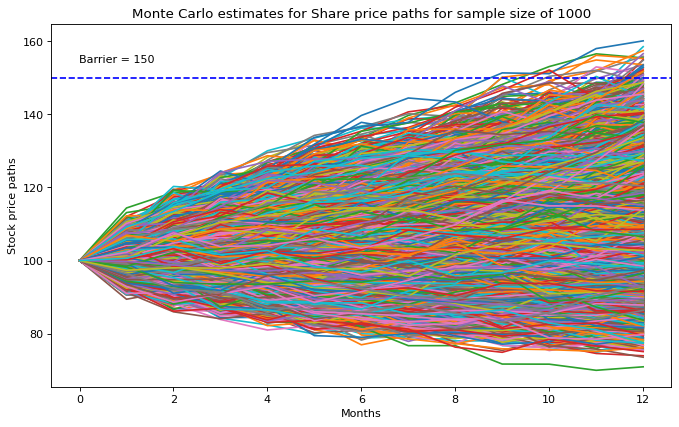

In [26]:
figure(figsize=(10, 6), dpi=80)
plt.plot(price_path_pd[0:1000])
plt.figtext(0.16,0.80,'Barrier = 150')
plt.title("Monte Carlo estimates for Share price paths for sample size of 1000")
plt.ylabel('Stock price paths',fontsize=10)
plt.xlabel('Months',fontsize=10)
plt.axhline(y = B, color = 'blue', linestyle = 'dashed') #This indicates the barrier level at $150
plt.show()

For illustration, below, we plot the Monte Carlo estimates for Firm values for sample size of 1000:

In [27]:
firm_price_pd = pd.DataFrame(firm_price) #Converting array to DataFrame
firm_row = pd.DataFrame([V_0]*n_simulations)
firm_price_pd = pd.concat([firm_row.T, firm_price_pd.T]) #Set first row to current firm value = $200 
firm_price_pd = firm_price_pd.reset_index(drop=True)

*(Please note that plotting might take a few mins to finish.)*

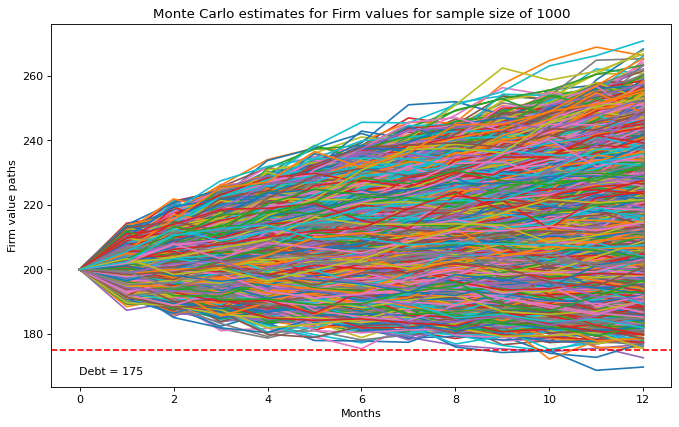

In [28]:
figure(figsize=(10, 6), dpi=80)
plt.plot(firm_price_pd[0:1000])
plt.figtext(0.16,0.15,'Debt = 175')
plt.title("Monte Carlo estimates for Firm values for sample size of 1000")
plt.ylabel('Firm value paths',fontsize=10)
plt.xlabel('Months',fontsize=10)
plt.axhline(y = debt, color = 'red', linestyle = 'dashed') #This indicates the debt level at $175
plt.show()

# Part 2

Calculate the one-year discount factor which applies for each simulation, and use this to find first the value of the option for the jointly simulated stock and firm paths with no default risk, and then the value of the option with counterparty default risk. (Hint: you may want to use the reshape and ravel attributes of numpy arrays to ensure your dimensions match correctly).

The one-year discount factor:

In [29]:
one_year_discount_factor = 1/np.cumprod(1+libor_forward, axis=1)[:,-1]
print(one_year_discount_factor)

[0.92347903 0.92498901 0.93847132 ... 0.92468339 0.93226964 0.91373541]


Since, we have the one-year discount factor, in order to get the default-free value of the option, we will multiply the discount factor with the up and out option payoff, then calculate the mean:

In [30]:
default_free_option = up_and_out_payoff*one_year_discount_factor
default_free_option_price = default_free_option.mean()
print("The Default-free option value is {:.2f}.".format(default_free_option_price))
print("The Standard deviation of the default-free option is {:.4f}.".format(up_and_out_price_std[i-1]))

The Default-free option value is 8.75.
The Standard deviation of the default-free option is 0.0278.


The value of the option with counterparty default risk:

In [31]:
CVA_adjusted_option_price = default_free_option_price - cva_estimates[i-1]
print("The CVA-adjusted option value is {:.2f}.".format(CVA_adjusted_option_price))
print("The Standard deviation of the CVA is {:.4f}.".format(cva_std[i-1]))

The CVA-adjusted option value is 7.74.
The Standard deviation of the CVA is 0.0105.


## Question 3:

If you bought the option (rather than sold it), how does your own credit risk affect the value
of the option?

As the buyer of the option, we will pay only the premium to the seller, and we have no delivery obligation, thus our risk is limited to the premium which we pay when we purchase the option. In this case as a buyer we are not a credit risk to the seller, but the seller is a potential credit risk to us. 

Therefore as a buyer of the option our credit risk should not affect the value of the option.

## Question 4:
Suppose interest rates increased 25 basis points. What is the new value of your option?

If interest rate increase by 25 bps, that should increase the value of the option, by Rho amount.

So, first we create a function which finds the Rho value for call options:

In [32]:
def rho_call(r, S, K, T, sigma):
    "Calculate rho of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    rho_calc = K*T*np.exp(-r*T)*norm.cdf(d2, 0, 1)
    return rho_calc*0.01

This function calculates the amount change in the option's price for each 1% change in the risk-free rate.

But we need the amount change if the risk-free rate increases by 25bps (0.25%), so we divide the Rho by 4:

In [33]:
rho_25bps = rho_call(r, S_0, K, T, sigma_stock)/4
print("If interest rates increase by 25bps, our option value will increase by {:.4f}.".format(rho_25bps))

If interest rates increase by 25bps, our option value will increase by 0.1261.


Suppose the libor rates will increase by 25bps, so we add 0.0025 to our discount factor calculation:

In [34]:
one_year_discount_factor_25bps = 1/np.cumprod(1+(libor_forward+0.0025),1)[:,-1]

The new default-free value of the option after 25bps increase:

In [35]:
default_free_option_price_25bps = (up_and_out_price[i-1]+rho_25bps)*one_year_discount_factor_25bps.mean()
print("The new Default-free option value is {:.2f}.".format(default_free_option_price_25bps))

The new Default-free option value is 8.60.


The new value of the CVA adjusted option after 25bps increase:

In [36]:
CVA_adjusted_option_price_25bps = default_free_option_price_25bps - cva_estimates[i-1]
print("The new CVA-adjusted option value is {:.2f}.".format(CVA_adjusted_option_price_25bps))

The new CVA-adjusted option value is 7.59.
